In [ ]:
import numpy as np
from scipy.integrate import simpson
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline

C_LIGHT = 299792.458  # km/s
LN10    = np.log(10.0)

In [ ]:
import numpy as np
from scipy.integrate import simpson
from scipy.stats import norm


def r2cz(r, H0):
    return r * H0

def r2mu(r):
    return 5 * (np.log10(r) + 5)


def get_psel(r, H0, cz_lim=None, sigma_cz=300, mu_lim=None, sigma_mu=0.1, make_plot=False):
    """Selection function: probability of inclusion in sample."""
    p = r**2
    if cz_lim is not None:
        p *= norm(loc=cz_lim, scale=sigma_cz).sf(r2cz(r, H0))
    
    if mu_lim is not None:
        p *= norm(loc=mu_lim, scale=sigma_mu).sf(r2mu(r))

    if make_plot:
        plt.figure()
        plt.plot(r, p)
        plt.show()

    return simpson(p, x=r)


In [ ]:
r = np.linspace(1, 300, 1000)
H0 = np.linspace(40, 100, 100)

cz_lim = r2cz(50, H0=70)
# cz_lim = None
# mu_lim = r2mu(60)
mu_lim = None

# get_psel(r, H0=70, cz_lim=3500, sigma_cz=250, make_plot=True)

y0 = [get_psel(r, H0=H0_i, cz_lim=cz_lim, mu_lim=mu_lim, ) for H0_i in H0]
y = [get_psel(r, H0=H0_i, cz_lim=cz_lim, mu_lim=mu_lim) for H0_i in H0]

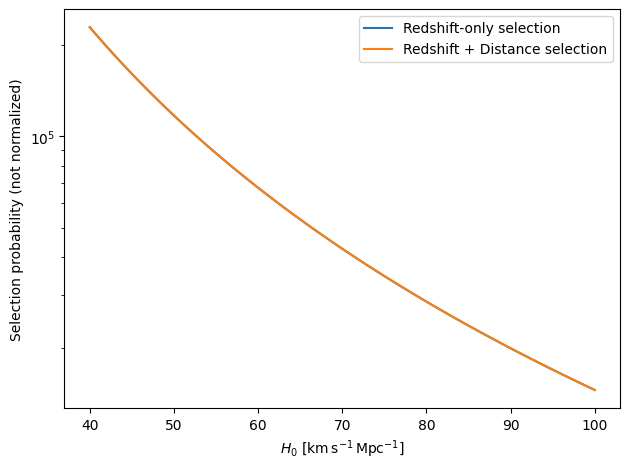

In [ ]:
plt.figure()
plt.plot(H0, y0, label="Redshift-only selection")
plt.plot(H0, y, label="Redshift + Distance selection")


plt.yscale('log')
# plt.xscale('log')

plt.legend()
plt.xlabel(r"$H_0 ~ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"Selection probability (not normalized)")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/selection_dependence.png", dpi=200)

plt.show()

### Test some equations

In [ ]:
n = 10000
H0_true = 70
sigma_mu = 0.4
sigma_vpec = 0
M = 0


v_obs, mu_obs, r_true = simulate_catalog(
    n=n, H0_true=H0_true, sigma_mu=sigma_mu, sigma_vpec=sigma_vpec)


In [ ]:
k = 0

logr_pred = (mu_obs - M) / 5 - 5 +  k * sigma_mu**2 * LN10 / 25

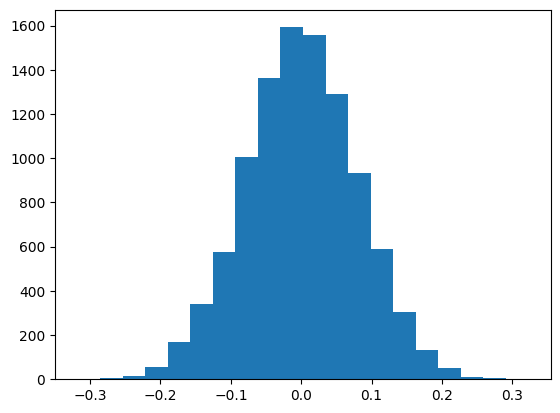

In [ ]:
plt.figure()
plt.hist(np.log10(r_true) - logr_pred, bins=20)

plt.show()

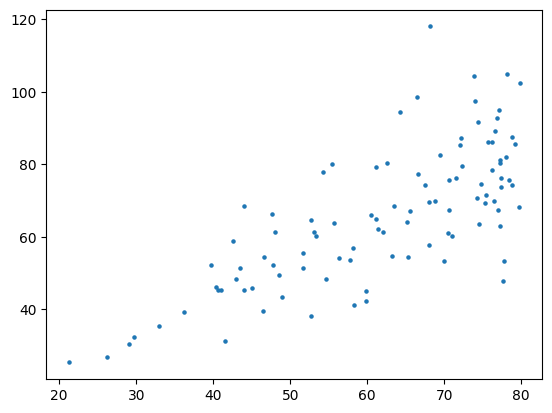

In [ ]:
plt.figure()
plt.scatter(r_true, 10**logr_pred, s=5)

plt.show()

### Numpyro test

In [ ]:
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from jax import random
from jax import numpy as jnp

def model(Vcmb, mu_obs, sigma_mu, k, rmin, rmax, apply_in_bounds=False):
    N = len(mu_obs)

    H0_max = Vcmb.min() / rmin
    H0_min = Vcmb.max() / rmax

    # H0 = sample("H0", Uniform(60.0, 90.0))  # broad prior
    H0 = sample("H0", Uniform(A60.0, 90.0))  # broad prior


    r = Vcmb / H0

    with plate("data", N):
        logp_elems = k * jnp.log(r)

        if apply_in_bounds:
            in_bounds = (r >= rmin) & (r <= rmax)
            logp = jnp.where(in_bounds, logp_elems, -jnp.inf)
        else:
            logp = logp_elems

        jac = - jnp.log(H0)
        factor("distance_prior_delta", logp + jac)
        sample("m_obs", Normal(5.0 * jnp.log10(r) + 25.0, sigma_mu), obs=mu_obs)

In [ ]:
catalogue_kwargs = dict(n=10000, rmin=5.0, rmax=100.0, 
                        H0_true=73.0, sigma_mu=0.4, sigma_vpec=0,)

nrepeat = 1000
H0_min = np.empty(nrepeat)
for i in range(nrepeat):
    Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=i)
    H0_min[i] = Vcmb.max() / catalogue_kwargs["rmax"]


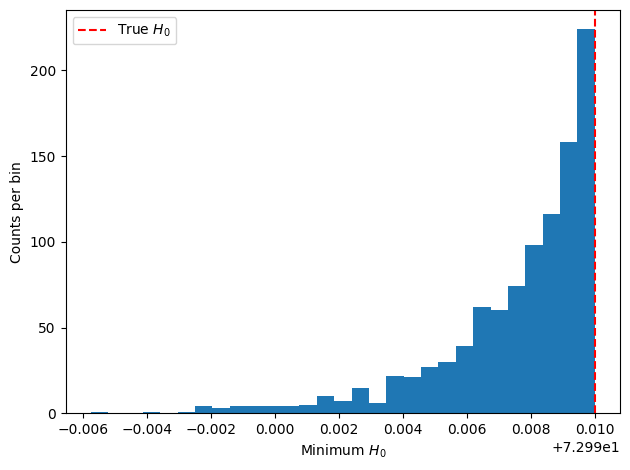

In [ ]:
plt.figure()
plt.hist(H0_min, bins="auto")
plt.axvline(catalogue_kwargs["H0_true"], color="red", ls="--", label=r"True $H_0$")
plt.xlabel(r"Minimum $H_0$")
plt.ylabel("Counts per bin")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/min_H0.png", dpi=150)

plt.show()

In [ ]:


catalogue_kwargs = dict(n=500, rmin=5.0, rmax=80.0, 
                        H0_true=73.0, sigma_mu=0.4, sigma_vpec=0,)

fit_kwargs = dict(sigma_mu=catalogue_kwargs["sigma_mu"], 
                  k=2, 
                  rmin=catalogue_kwargs["rmin"], 
                  rmax=catalogue_kwargs["rmax"],
                  apply_in_bounds=True)

nrepeat = 100
H0_mean = np.zeros(nrepeat)
H0_std  = np.zeros(nrepeat)

kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=1,
            progress_bar=nrepeat==1)

for i in trange(nrepeat):
    Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=i)
    mcmc.run(random.PRNGKey(i),
             Vcmb=jnp.asarray(Vcmb),
             mu_obs=jnp.asarray(mu_obs),
             **fit_kwargs)
    samples = mcmc.get_samples()

    H0 = samples["H0"]
    H0_mean[i] = H0.mean()
    H0_std[i]  = H0.std()
    if nrepeat == 1:
        print(f"H0: {H0.mean():.3f} ± {H0.std():.3f} km/s/Mpc")
# print(f"k: {k_inferred.mean():.3f} ± {k_inferred.std():.3f}")

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


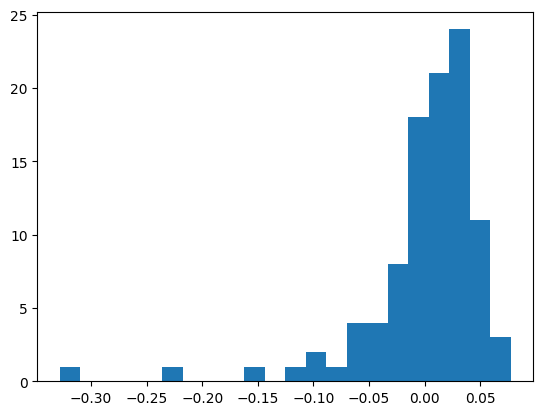

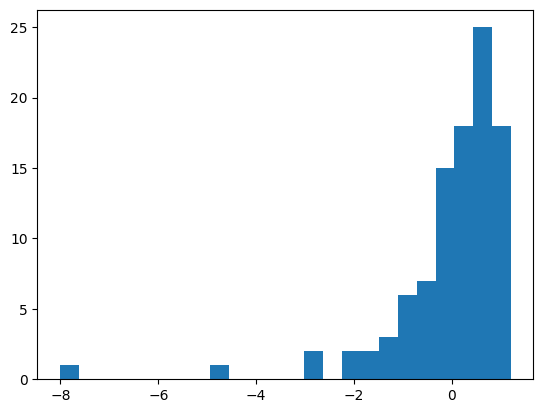

In [ ]:
plt.figure()
plt.hist(H0_mean - catalogue_kwargs["H0_true"], bins="auto")
plt.show()

plt.figure()
plt.hist((H0_mean - catalogue_kwargs["H0_true"]) / H0_std, bins="auto")
plt.show()

In [ ]:
def log_pdf_gauss(x, mu, sigma):
    """Log of Gaussian PDF."""
    return -0.5 * ((x - mu)/sigma)**2 - 0.5 * np.log(2 * np.pi * sigma**2)

def fit_H0_options(Vcmb, mu_obs, sigma_mu=0.4, sigma_vpec=300, qj_model=0,
           which="r_marg", h0_min=60.0, h0_max=85.0, h0_step=0.025,
           rmin=0, rmax=80, rstep=100, k=2):
    """Grid posterior for H0."""
    H0_grid = np.arange(h0_min, h0_max + 0.5*h0_step, h0_step)
    print(f"H0 grid: {H0_grid.size} points from {H0_grid[0]:.3f} to {H0_grid[-1]:.3f} km/s/Mpc")

    def logpost(H0):
        if which == "r_marg":
            assert qj_model == 0, "Distance marg. only for qj_model=0."
            rgrid = np.linspace(rmin, rmax, rstep)
            mu_grid = 5 * np.log10(rgrid) + 25.0

            # Log prior on distance, shape: (n_rgrid,)
            lp_r = k * np.log(rgrid)

            # Log-likelihood of "mu_obs": shape: (n_data, n_rgrid)
            ll_mu = log_pdf_gauss(mu_obs[:, None], mu_grid[None, :], sigma_mu)

            # Log-likelihood of "Vcmb": shape: (n_data, n_rgrid)
            ll_cz = log_pdf_gauss(
                Vcmb[None, :, None], H0 * rgrid[None, None, :],
                sigma_vpec)

            # Log-density of the model: shape: (n_data, n_rgrid)
            lp = lp_r[None, :] + ll_mu[None, ...] + ll_cz
            # Marginalise over the distance grid, shape: (n_data)
            lp = np.log(simpson(np.exp(lp), x=rgrid, axis=-1))
            # Sum over data points, shape: (n_H0,)
            lp = np.sum(lp)
        elif which == "r_correction":
            assert qj_model == 0
            mu_th = 5 * np.log10(Vcmb / H0) + 25.0
            lp = log_pdf_gauss(mu_obs, mu_th, sigma_mu).sum()
            lp += 0.6 * LN10 * np.sum(mu_th)  # uniform
        elif which == "freq":
            mu_th = 5 * np.log10(Vcmb / H0) + 25.0
            lp = log_pdf_gauss(mu_obs, mu_th, sigma_mu).sum()
        else:
            raise ValueError(f"Unknown which={which}")

        return lp

    lp = np.array([logpost(h) for h in H0_grid])
    # stabilize and normalize
    p = np.exp(lp - lp.max())
    norm = np.trapz(p, H0_grid)
    if np.isfinite(norm) and norm>0:
        p /= norm
    cdf = np.cumsum(p) * (H0_grid[1]-H0_grid[0])

    # Handle potential numeric peculiarities at tails
    h0_16, h0_50, h0_84 = np.interp(
        [0.16, 0.50, 0.84], cdf, H0_grid, left=H0_grid[0], right=H0_grid[-1])
    return H0_grid, p, (h0_16, h0_50, h0_84)

In [ ]:
n = 1000
rmin = 5
rmax = 80
H0_true = 73.0
sigma_m = 0.4
sigma_vpec = 300

seed = 48

catalogue_kwargs = dict(
    n=n, rmin=rmin, rmax=rmax, H0_true=H0_true,
    sigma_m=sigma_m, sigma_vpec=sigma_vpec,)
fit_kwargs_options = dict(
    sigma_mu=sigma_m, sigma_vpec=sigma_vpec, qj_model=0,
    h0_min=65.0, h0_max=85.0, h0_step=0.025, rmin=rmin, rmax=rmax, rstep=250)

v_obs, mu_obs = simulate_catalog(**catalogue_kwargs, seed=seed)


In [ ]:
H0_grid, p_rmarg, (H0_low_rmarg, H0_med_rmag, H0_high_rmarg) = fit_H0_options(v_obs, mu_obs, which="r_marg", **fit_kwargs_options)
H0_grid, p_chi2, (H0_low_chi2, H0_med_chi2, H0_high_chi2) = fit_H0_options(v_obs, mu_obs, which="freq", **fit_kwargs_options)
H0_grid, p_rcorr, (H0_low_rcorr, H0_med_rcorr, H0_high_rcorr) = fit_H0_options(v_obs, mu_obs, which="r_correction", **fit_kwargs_options)

print("\n=== H0 posteriors ===")
print(f"True H0: {H0_true:.3f} km/s/Mpc")
print(f"r_marg:       median={H0_med_rmag:.3f}  [16,84]=[{H0_low_rmarg:.3f}, {H0_high_rmarg:.3f}]")
print(f"Chi2-like:    median={H0_med_chi2:.3f}  [16,84]=[{H0_low_chi2:.3f}, {H0_high_chi2:.3f}]")
print(f"r_corr :      median={H0_med_rcorr:.3f}  [16,84]=[{H0_low_rcorr:.3f}, {H0_high_rcorr:.3f}]")



H0 grid: 801 points from 65.000 to 85.000 km/s/Mpc
H0 grid: 801 points from 65.000 to 85.000 km/s/Mpc
H0 grid: 801 points from 65.000 to 85.000 km/s/Mpc

=== H0 posteriors ===
True H0: 73.000 km/s/Mpc
r_marg:       median=72.750  [16,84]=[72.470, 73.033]
Chi2-like:    median=72.622  [16,84]=[72.202, 73.044]
r_corr :      median=65.615  [16,84]=[65.276, 65.981]


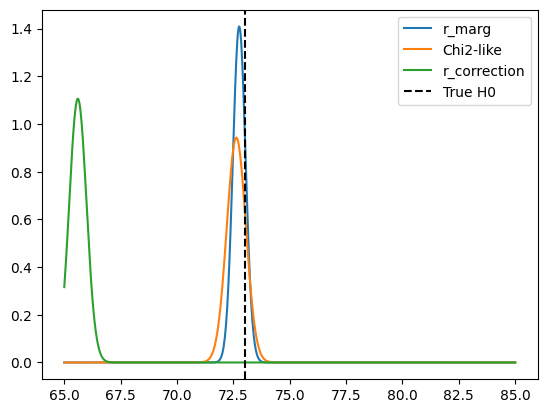

In [ ]:
plt.figure()
plt.plot(H0_grid, p_rmarg, label="r_marg", color="C0")
plt.plot(H0_grid, p_chi2, label="Chi2-like", color="C1")    
plt.plot(H0_grid, p_rcorr, label="r_correction", color="C2")


plt.axvline(H0_true, color="k", linestyle="--", label="True H0")

plt.legend()

# plt.xlim(70, 80)/

plt.show()

### $\chi^2$ bias test

In [ ]:
n = 1000
rmin = 5
rmax = 80
H0_true = 73.0
sigma_mu = 0.2
sigma_vpec = 300

seed = 48

catalogue_kwargs = dict(
    n=n, rmin=rmin, rmax=rmax, H0_true=H0_true,
    sigma_m=sigma_mu, sigma_vpec=sigma_vpec, )
fit_kwargs = dict(sigma_mu=sigma_mu, sigma_vpec=sigma_vpec, h0_min=50, h0_max=100.0, h0_step=0.01)

In [ ]:
def fit_H0(Vcmb, mu_obs, sigma_mu=0.4, sigma_vpec=None,
           h0_min=60.0, h0_max=85.0, h0_step=0.025, verbose=True, k=-1):
    """Grid posterior for H0."""
    H0_grid = np.arange(h0_min, h0_max + 0.5*h0_step, h0_step)
    if verbose:
        print(f"H0 grid: {H0_grid.size} points from {H0_grid[0]:.3f} to {H0_grid[-1]:.3f} km/s/Mpc")

    m = Vcmb > 0
    Vcmb, mu_obs = Vcmb[m], mu_obs[m]

    if sigma_vpec is not None:
        sigma_mu = np.sqrt(sigma_mu**2 + (5.0 / np.log(10.0) * sigma_vpec / Vcmb)**2)
    else:
        sigma_mu = np.ones_like(mu_obs) * sigma_mu

    # Shape `(n_H0, n_data)`
    lp = log_pdf_gauss(mu_obs[None, :], 5 * np.log10(Vcmb[None, :] / H0_grid[:, None]) + 25.0, sigma_mu[None, :])
    lp -= (k + 1) * np.log(H0_grid[:, None])

    # Shape `(n_H0, )`
    lp = np.sum(lp, axis=-1)

    # stabilize and normalize
    p = np.exp(lp - lp.max())
    norm = simpson(p, x=H0_grid)
    if np.isfinite(norm) and norm>0:
        p /= norm

    H0_mean = simpson(p * H0_grid, x=H0_grid)
    H0_std = np.sqrt(simpson(p * (H0_grid - H0_mean)**2, x=H0_grid))

    return H0_mean, H0_std


def bias_H0(H0_true, sigma_v, rmin, rmax):
    E_inv_r2 = 3 * (rmax - rmin) / (rmax**3 - rmin**3)
    
    bias = -(sigma_v**2) / (2 * H0_true) * E_inv_r2
    return bias

def rk_draw(n, rmin, rmax, k, rng):
    assert k > -1
    u = rng.random(n)
    return (rmin**(k+1) + u * (rmax**(k+1) - rmin**(k+1)))**(1/(k+1))

def bias_H0_with_propagation(H0_true, sigma_v, sigma_mu, rmin, rmax, k=2,
                             n_mc=200_000, seed=0):
    """
    MC estimate of E[ H0_hat - H0_true ] when sigma_v is propagated into sigma_mu.
    Returns the leading-order bias (negative means underestimation).
    """
    rng = np.random.default_rng(seed)
    r = rk_draw(n_mc, rmin, rmax, k, rng)
    a = (5.0 / np.log(10.0))**2 * (sigma_v**2) / (H0_true**2)
    w = 1.0 / (sigma_mu**2 + a / r**2)           # weights from propagated sigma
    num = np.mean(w * (sigma_v**2 / r**2))
    den = np.mean(w)
    return -0.5 * num / (H0_true * den)

In [ ]:
bias_H0(H0_true, sigma_vpec, rmin, rmax)

-0.27096191479753123

In [ ]:
i = 0

catalogue_kwargs["n"] = 1000
catalogue_kwargs["sigma_vpec"] = 50

Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=i)

fit_H0(Vcmb, mu_obs, **fit_kwargs, k=-1)

H0 grid: 5001 points from 50.000 to 100.000 km/s/Mpc


(73.34653794410552, 0.26966729137702083)

In [ ]:
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from jax import random
from jax import numpy as jnp

# def model(Vcmb, mu_obs, sigma_mu, sigma_vpec, k, rmin, rmax):
#     n = len(mu_obs)
#     H0 = sample("H0", Uniform(50.0, 100.0))
# 
#     # k = sample("k", Uniform(0, 5))
# 
#     with plate("data", n):
#         r = sample("r", Uniform(rmin, rmax))
#         # factor("lp_r", k * jnp.log(r) - jnp.log(rmax**(k+1) - rmin**(k+1)))
#         factor(
#             "lp_r",
#             k * jnp.log(r)
#             # + jnp.log(k + 1.0)
#             # - jnp.log(rmax**(k + 1.0) - rmin**(k + 1.0)),
#             )
# 
#         mu_th = 5 * jnp.log10(r) + 25.0
#         sample("mu", Normal(mu_th, sigma_mu), obs=mu_obs)
#         v_th = H0 * r
#         sample("v", Normal(v_th, sigma_vpec), obs=Vcmb)


def model(Vcmb, mu_obs, sigma_mu, sigma_vpec, k, rmin, rmax):
    N = len(mu_obs)
    H0 = sample("H0", Uniform(50.0, 90.0))  # broad prior

    r = Vcmb / H0

    # Impose the distance prior via a factor term, and include the Jacobian from the delta constraint.
    # Prior on d: proportional to d^2 (uniform in volume) or 1/d (flat-μ) on [d_min, d_max].
    logp_elems = k * jnp.log(r)
    # logp = logp_elems
    in_bounds = (r >= rmin) & (r <= rmax)
    logp = jnp.where(in_bounds, logp_elems, -jnp.inf)
    # Jacobian from δ(z - H0 d / c) when integrating out d gives factor (c / H0) per datum
    jac = - jnp.log(H0)
    factor("distance_prior_delta", jnp.sum(logp) + N * jac)

    # Only magnitude likelihood remains
    m_mean = 5.0 * jnp.log10(r) + 25.0
    sample("m_obs", Normal(m_mean, sigma_mu), obs=mu_obs)


kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel,
            num_warmup=500, num_samples=500, num_chains=1, progress_bar=True)

mcmc.run(random.PRNGKey(i),
         Vcmb=jnp.asarray(Vcmb),
         mu_obs=jnp.asarray(mu_obs),
         sigma_mu=catalogue_kwargs["sigma_m"],
         sigma_vpec=catalogue_kwargs["sigma_vpec"],
         k=2,
         rmin=rmin,
         rmax=rmax
         )
samples = mcmc.get_samples()

H0 = samples["H0"]
# k_inferred = samples["k"]
print(f"H0: {H0.mean():.3f} ± {H0.std():.3f} km/s/Mpc")
# print(f"k: {k_inferred.mean():.3f} ± {k_inferred.std():.3f}")


sample: 100%|██████████| 1000/1000 [00:00<00:00, 2552.79it/s, 1 steps of size 1.20e-01. acc. prob=0.74]

H0: 73.808 ± 0.015 km/s/Mpc


In [ ]:
(Vcmb / rmax).max()

72.93206180486557

In [ ]:
(Vcmb / rmin).min()

168.1166421075266

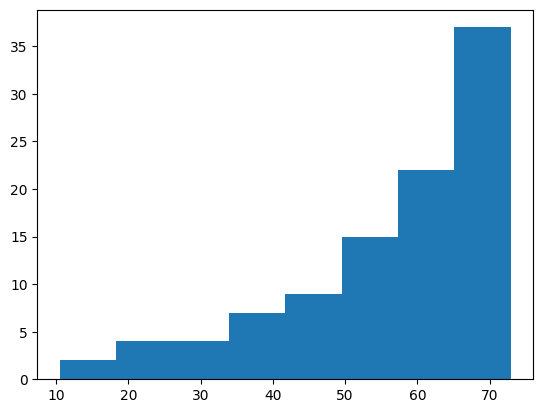

In [ ]:
plt.figure()
# plt.hist((Vcmb / rmin), bins="auto")
plt.hist((Vcmb / rmax), bins="auto")
plt.show()

In [ ]:
Vcmb.min() / rmax, Vcmb.max() / rmin

(10.691067442341135, 1255.8424988275021)

In [ ]:
nrepeat = 1000
H0_mean = np.empty(nrepeat)
H0_std  = np.empty(nrepeat)

for i in trange(nrepeat):
    Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=i)
    H0_mean[i], H0_std[i] = fit_H0(Vcmb, mu_obs, **fit_kwargs, verbose=False)

100%|██████████| 1000/1000 [00:30<00:00, 32.77it/s]


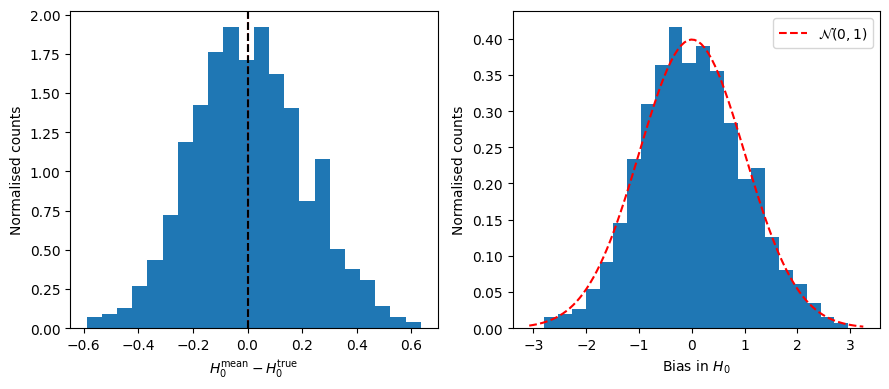

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].hist(H0_mean - H0_true, bins="auto", density=True)
axes[0].axvline(bias_H0(H0_true, sigma_vpec, rmin, rmax), color="red", ls="--", label="Predicted bias")
axes[0].axvline(0, color="k", ls="--", label="No bias")
axes[0].set_xlabel(r"$H_0^{\rm mean} - H_0^{\rm true}$")

axes[1].hist((H0_mean - H0_true) / H0_std, bins="auto", density=True)
xlim = axes[1].get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
axes[1].plot(x, norm.pdf(x), color="red", label=r"$\mathcal{N}(0, 1)$", ls="--")
axes[1].set_xlabel(r"Bias in $H_0$")
axes[1].legend()

for i in range(2):
    axes[i].set_ylabel("Normalised counts")

fig.tight_layout()
fig.savefig("chi2_mocks.png", dpi=450)
plt.show()

In [ ]:
nrepeat = 100
sigma_m_all = np.linspace(0.1, 0.6, 8)
# sigma_m_all = np.linspace(100, 2500, 10)

H0_mean = np.empty((len(sigma_m_all), nrepeat))
H0_std = np.empty((len(sigma_m_all), nrepeat))

for i, sigma_m in enumerate(sigma_m_all):
    print(f"sigma_m = {sigma_m}")
    for j in range(nrepeat):
        # catalogue_kwargs['sigma_m'] = 0.2
        # fit_kwargs['sigma_mu'] = 0.2
        # catalogue_kwargs["n"] = int(sigma_m)
        catalogue_kwargs['sigma_m'] = sigma_m
        fit_kwargs['sigma_mu'] = sigma_m
        catalogue_kwargs["n"] = 500
        Vcmb, mu_obs = simulate_catalog(**catalogue_kwargs, seed=(i + 1) * (j + 1))
        H0_mean_i, H0_std_j = fit_H0(Vcmb, mu_obs, **fit_kwargs, verbose=False)
        H0_mean[i, j] = H0_mean_i
        H0_std[i, j]  = H0_std_j





sigma_m = 0.1
sigma_m = 0.17142857142857143
sigma_m = 0.24285714285714285
sigma_m = 0.3142857142857143
sigma_m = 0.3857142857142857
sigma_m = 0.4571428571428571
sigma_m = 0.5285714285714286
sigma_m = 0.6


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_18355/3060273581.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


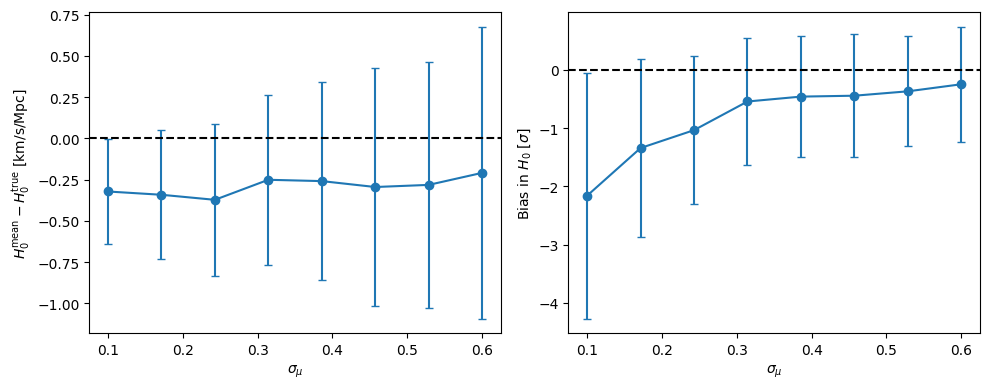

In [ ]:
dH0 = H0_mean - H0_true
H0_bias = dH0 / H0_std

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].errorbar(sigma_m_all, np.mean(dH0, axis=1), yerr=np.std(dH0, axis=1), fmt='o-', capsize=3)


# delta_mu = 0.25 * LN10 * sigma_m_all**2
# y = catalogue_kwargs["H0_true"] * (1 - 10.0**(-delta_mu / 5.0))
# axs[0].plot(sigma_m_all, y, label='Analytic prediction', color='C1')

axs[1].errorbar(sigma_m_all, np.mean(H0_bias, axis=1), yerr=np.std(H0_bias, axis=1), fmt='o-', capsize=3)

for i in range(2):
    axs[i].axhline(0, color='k', ls='--')
    axs[i].set_xlabel(r'$\sigma_\mu$')

axs[0].set_ylabel(r'$H_0^{\rm mean} - H_0^{\rm true}$ [km/s/Mpc]')
axs[1].set_ylabel(r'Bias in $H_0$ [$\sigma$]')

fig.tight_layout()
fig.savefig("chi2_mocks_vary_sigma_m.png", dpi=450)
fig.show()

In [ ]:
def bias_H0(H0_true, sigma_v, rmin, rmax):
    # E[1/r^2] for volumetric distribution
    E_inv_r2 = 3 * (rmax - rmin) / (rmax**3 - rmin**3)
    
    bias = -(sigma_v**2) / (2 * H0_true) * E_inv_r2
    return bias

In [ ]:
bias_H0(73.0, 300.0, 5.0, 80.0)

-0.27096191479753123

In [ ]:
sigma_m_all = np.linspace(0.1, 0.6, 8)
nrepeat = 100


H0_hat = np.empty((len(sigma_m_all), nrepeat))

alpha = 5 / np.log(10)


for i, sigma_m in enumerate(sigma_m_all):
    for j in range(nrepeat):
        catalogue_kwargs['sigma_m'] = sigma_m
        fit_kwargs['sigma_mu'] = sigma_m
        catalogue_kwargs["n"] = 500
        Vobs, mu = simulate_catalog(**catalogue_kwargs, seed=(i + 1) * (j + 1))

        m = Vobs > 0
        Vobs, mu = Vobs[m], mu[m]

        k = 2
        kappa = - sigma_m**2 * (1 + k) / alpha

        H0_hat[i, j] = 10**(np.mean(5 - (mu + kappa) / 5 + np.log10(Vobs)))

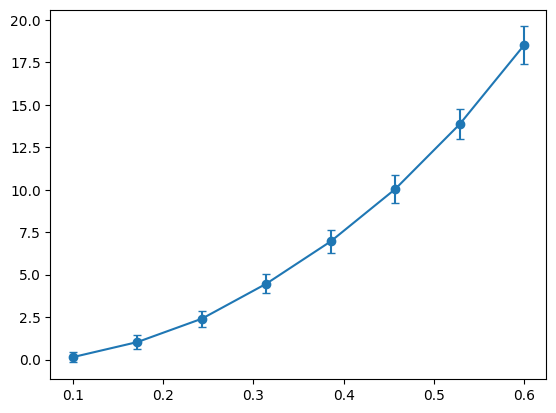

In [ ]:
H0_hat_mean = np.mean(H0_hat, axis=1)
H0_hat_std  = np.std(H0_hat, axis=1)

plt.figure()

plt.errorbar(sigma_m_all, H0_hat_mean - catalogue_kwargs["H0_true"], yerr=H0_hat_std, fmt='o-', capsize=3)
plt.show()

